# Lab 3: Vector Data and Linear Regressions
Being able to open and work with different types of geospatial data is a fundamental skill. Whether your data is stored locally, on a network drive, or in an online repository, you need to know how to access it before you can analyze or visualize it.

This lab introduces key Python packages for handling vector data and mapping. By the end of this session, you'll be able to load various types of geospatial files and start visualizing them. Additionally, we will introduce parsing time series data and analyzing time series using trend analysis.

**New Packages:**

In this lab, we'll work with the following libraries:

- *Pandas* – for handling tabular data (e.g., attribute tables).
- *Geopandas* – for working with spatial vector data.
- *Cartopy* – for creating maps and handling projections.



In [1]:
# Preamble
import cartopy.crs as ccrs                # Coordinate Reference Systems (CRS) in Cartopy
import cartopy.feature as cfeature        # Cartopy's built-in map features
import matplotlib.pyplot as plt           # Plotting library
import pandas as pd                       # Data manipulation with Pandas
import geopandas as gpd                   # Spatial data handling with Geopandas

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# Cartopy

Cartopy is a Python package designed to simplify map-making with Matplotlib. However, working with projections and coordinate reference systems (CRS) can sometimes be tricky.

Cartopy integrates directly with Matplotlib. You create an axes object, define a projection, and then add built-in map features such as coastlines or background imagery.

**Cartopy’s Projection Reference**
A list of named projections with examples is available here: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

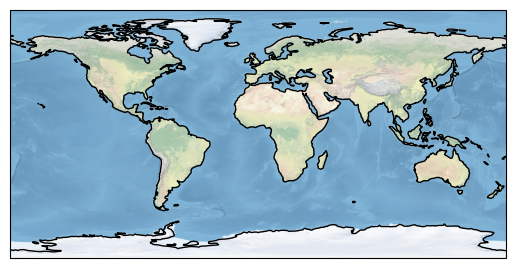

In [2]:
# Create a figure and specify the projection
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())  # Plate Carrée projection (default lat/lon grid)

# Alternative: Use an EPSG code to define a projection (e.g., BC Albers: EPSG 3005)
# ax = plt.axes(projection=ccrs.epsg(3005))

# Add basic features
ax.coastlines()   # Add coastlines
ax.stock_img()    # Add a low-resolution background image (land/ocean/topography)

## Comparing Different Projections

Let's now create multiple world maps, each using a different projection. We can create a list of projections, then use a loop to generate a map for each one.

Some projections distort area, while others distort shape. Think about what works best for your data!

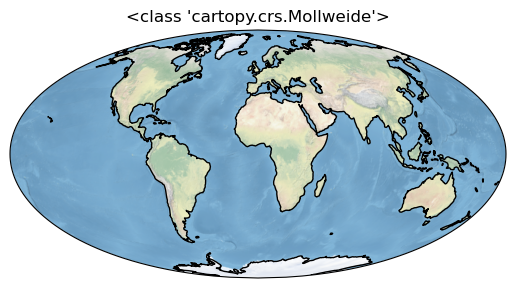

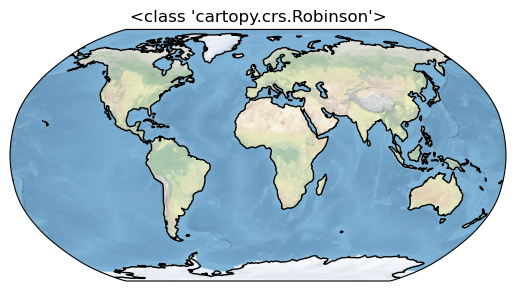

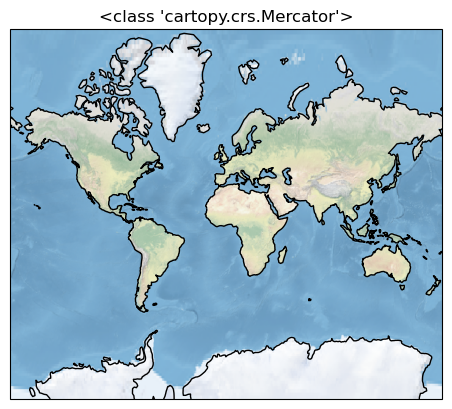

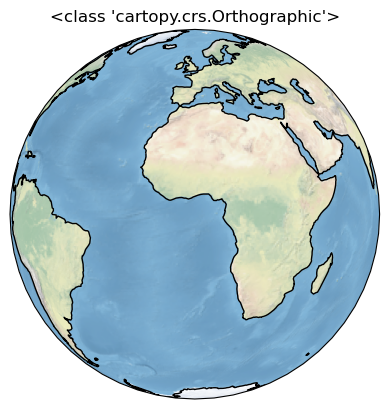

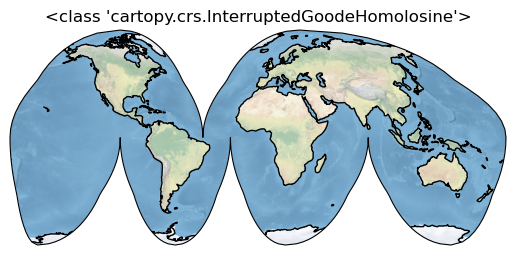

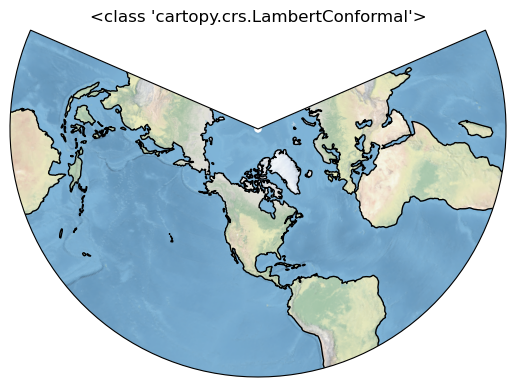

In [3]:
# List of projections to visualize
projections = [
    ccrs.Mollweide(),
    ccrs.Robinson(),
    ccrs.Mercator(),
    ccrs.Orthographic(),
    ccrs.InterruptedGoodeHomolosine(),
    ccrs.LambertConformal()
]

# Loop through the list and create a figure for each projection
for proj in projections:
    plt.figure() # Each loop iteration creates a new figure and axes
    ax = plt.axes(projection=proj)
    ax.stock_img()  # Add a background image
    ax.coastlines()  # Add coastlines
    ax.set_title(type(proj))  # Display projection name


**Exercise 1:** Choose a different projection (CRS) from the page here: https://scitools.org.uk/cartopy/docs/v0.13/crs/projections.html#cartopy-projections, and re-plot a basic map of the world with coastline features. Make the coastline pink (or any other named color: see here for a list - https://matplotlib.org/3.1.0/gallery/color/named_colors.html).  

## Creating Regional Maps

To create a regional map, we use the `set_extent` method of **GeoAxis** to define the boundaries of the map area. We can also add gridlines with labels for better orientation.

The **Albers Equal-Area** projection is commonly used for regional maps because it preserves area proportions. However, it requires two **standard parallels** as input when defining the map projection.

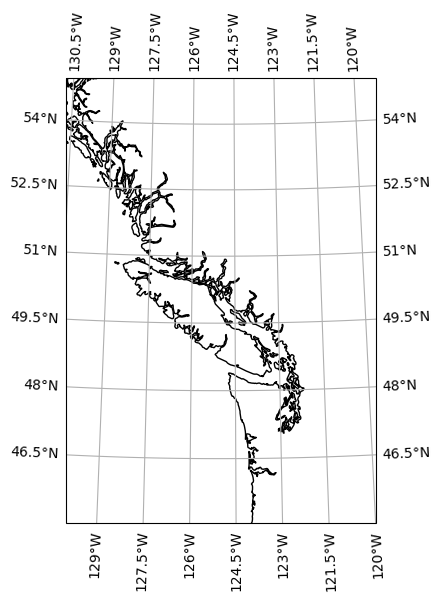

In [4]:
# Define the central longitude and latitude for the Albers projection
central_lon, central_lat = -125, 50

# Define the map extent [longitude (west, east), latitude (south, north)] in degrees
extent = [-130, -120, 45, 55]

# Create the figure
plt.figure(figsize=(4, 10))

# Create map axes with an Albers Equal-Area projection
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)  # Set the regional extent
ax.gridlines(draw_labels=True)  # Add gridlines with labels
ax.coastlines(resolution='10m')  # Add high-resolution coastlines

# Save the figure
plt.savefig('BC-coast.jpg', dpi=300)

## Adding Your Own Data to a Cartopy Map

Cartopy supports Matplotlib plotting commands (e.g., `plt.plot`, `plt.scatter`) we have worked with previously and can transform data into the correct coordinate reference system (CRS) for your base map. This means you can overlay points, lines, and polygons while ensuring they match the map’s projection.

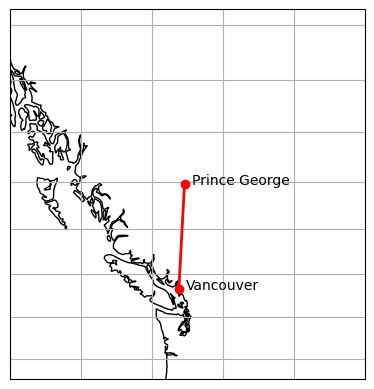

In [5]:
# Define latitude and longitude pairs for Prince George (PG) and Vancouver (VR)
PG_lat, PG_lon = 53.9, -122.7  # Prince George
VR_lat, VR_lon = 49.3, -123.1  # Vancouver

# Create figure
fig = plt.figure()

# Create map axes with a Mercator projection (Google's variant)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)

# Add coastlines with a medium resolution
ax.coastlines(resolution='50m')

# Add gridlines
ax.gridlines()

# Set the map extent [xmin, xmax, ymin, ymax] (longitude, latitude)
ax.set_extent([-135, -110, 45, 60])

# Plot the locations and draw a line between them
plt.plot(
    [PG_lon, VR_lon], [PG_lat, VR_lat],  # Longitude (x) and Latitude (y)
    color='red', linewidth=2, marker='o',  # Red line with markers
    transform=ccrs.PlateCarree()  # CRS of the input points (Plate Carrée = standard lat/lon). More on this below.
)

# Add labels for Prince George and Vancouver
## By specifying transform=ccrs.PlateCarree(), you tell Cartopy that the text coordinates are in lat/lon, and Cartopy will correctly project them onto the map.
plt.text(PG_lon + 0.5, PG_lat, 'Prince George', transform=ccrs.PlateCarree())
plt.text(VR_lon + 0.5, VR_lat, 'Vancouver', transform=ccrs.PlateCarree())

# Save the figure
plt.savefig('YXS-YVR.png', dpi=300)


### Understanding the `transform` Argument

When plotting data on a Cartopy map, the `transform` argument tells Cartopy what projection the data is originally in, not what it should be transformed to.

Why is this important?

- The map projection (set when creating the axes) determines how the map is displayed.
- The data projection (defined by `transform`) tells Cartopy how to reproject the data to match the map.
- This makes your code robust—you can change the map projection without modifying your data inputs.

# Working with Vector Data
## CSV Files

CSV files are a common format for storing point-based geospatial data. These files typically contain tabular data where values are separated by commas, with columns representing attributes such as latitude, longitude, elevation, and other associated values.

In this lab, we will work with a CSV file containing trends in snow depth at all BC snow stations. 

### Opening CSV Files with Pandas

Pandas is a powerful Python library for data manipulation and analysis. It allows us to easily read and process CSV files using a special data structure called a **DataFrame**. If you are familiar with R, Pandas DataFrames function similarly to R data frames.

The `read_csv` function reads the CSV file into a DataFrame, and `display(df)` provides an easy-to-read preview of the data.

In [6]:
# Define the file path
filename = 'data/bcsnowdepthswetrendsbystation1950-2014.csv'

# Read the CSV file, specifying the delimiter and header row
df = pd.read_csv(filename, delimiter=',', header=0)  

# Display the DataFrame
display(df)

,station_id,latitude,longitude,elevation,measure,slope_percentperyear,slope_lci,slope_uci,sigstat,intercept,start_year,end_year
0,1A05,53.950000,-121.433333,1693,swe,0.462782,0.059162,0.804084,True,-915.364369,1953,2014
1,1B01,53.716667,-126.416667,1489,swe,-0.127336,-0.476677,0.220633,False,251.437277,1953,2014
2,1B02,53.583333,-127.633333,1319,swe,0.199319,-0.035205,0.451716,False,-399.949880,1952,2014
3,1B06,53.350000,-125.266667,1596,swe,-0.170294,-0.531350,0.177117,False,337.079676,1953,2014
4,1B07,53.450000,-126.283333,1502,swe,-0.227871,-0.584958,0.132671,False,451.361593,1953,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
93,3A10,49.366667,-122.950000,1007,depth,-0.514669,-1.070323,0.112818,False,1030.805848,1950,2014
94,3B01,49.650000,-125.200000,1110,depth,-0.411571,-0.918675,0.160674,False,824.851130,1955,2014
95,3D02,49.033333,-120.850000,1254,depth,-0.825228,-1.353565,-0.349187,True,1653.571244,1950,2014
96,3D03A,49.116667,-121.300000,1134,depth,-1.404211,-2.654260,-0.185798,True,2820.478352,1950,2014


### Pandas DataFrames

A **DataFrame** is a 2-dimensional tabular data structure with labeled axes (rows and columns). In simple terms, it’s like an Excel spreadsheet that allows you to easily manipulate and analyze data. The power of Pandas is that you can perform powerful data operations without needing to manually manipulate data in a spreadsheet.

When working with a DataFrame, you can access individual columns by specifying their name. There are three common ways to do this:

1. Dictionary-style indexing: `df['column_name']`
    - This is the most common and flexible way to access a column.
2. Attribute-style access: `df.column_name`
    - This method works only if the column name is a valid Python attribute (i.e., no spaces, starts with a letter).
3. Index-based access: `df.iloc[row, column]`
    - This allows you to access data by row and column number, which can be useful for numerical indexing rather than column names.

In [7]:
# Access the first latitude value using different methods
print(df['latitude'][0])   # Method 1: Dictionary-style indexing
print(df.latitude[0])      # Method 2: Attribute-style access
print(df.iloc[0, 1])       # Method 3: Index-based access (row 0, column 1)              

53.95
53.95
53.95


### Creating Two Maps using a CSV

In this exercise, we will generate two maps using the CSV containing snow depth data. The first will simply display the locations of  stations using longitude and latitude coordinates. The second map will add color to the points based on the trend in snow depth.

**Map 1: Plotting Station Locations**

We will create a basic map showing the location of snow stations using their longitude and latitude values. To ensure Cartopy understands the coordinates are in longitude/latitude (degrees), we define the input as the `PlateCarree` projection.

(-2175848.1372350426, -1347534.6273523914)
(1276891.060671479, 2062176.756445776)


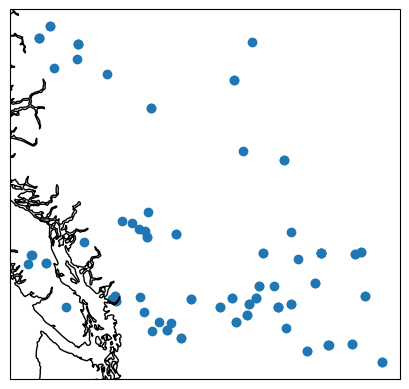

In [8]:
# Create the first map showing the location of the stations
plt.figure()

# Define the projection for the map
ax = plt.axes(projection=ccrs.LambertConformal())

# Add coastlines for better context
ax.coastlines(resolution='10m')             

# Plot the snow stations as points
# Longitude and latitude are transformed into the PlateCarree projection
plt.scatter(df.longitude, df.latitude,
            transform=ccrs.PlateCarree())   # Data are in lat/lon, so use PlateCarree as the CRS of the data

# Display the extent of the map (based on the data's bounding box)
print(plt.xlim())  # Print the x-axis (longitude) limits of the map
print(plt.ylim())  # Print the y-axis (latitude) limits of the map

**Map 2: Color-Coded Station Locations by Trend**

Now, we will modify the plot to color the points based on the trend in snow depth at each station. We’ll use a red-blue color palette (RdBu) to represent the trend (from negative to positive values).

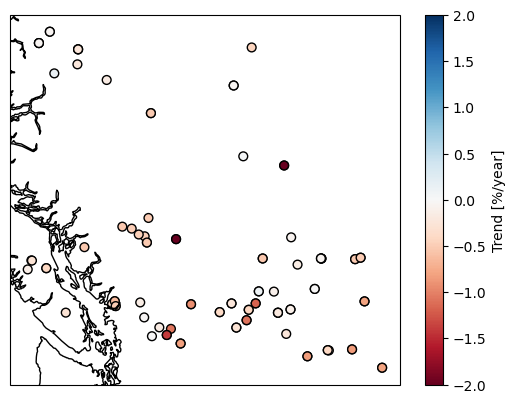

In [9]:
# Create a color-coded map showing the snow depth trend at each station
plt.figure()

# Define the projection for the map
ax = plt.axes(projection=ccrs.LambertConformal())

# Add coastlines for context
ax.coastlines(resolution='10m')

# Plot the stations with colors representing the trend magnitude
plt.scatter(df.longitude, df.latitude, 
            c=df.slope_percentperyear,  # Color by snow depth trend
            s=40,                       # Increase point size for visibility
            vmin=-2, vmax=2,            # Set color scale to range from -2% to 2%
            cmap='RdBu',                # Red-blue colormap
            edgecolor='black',          # Black border for each point
            transform=ccrs.PlateCarree())  # Data CRS is PlateCarree

# Add a colorbar to the map to show trend values
cb = plt.colorbar()                        # Add colorbar
cb.set_label('Trend [%/year]')             # Label the colorbar

**Exercise 2:** Create a scatter plot of snow trend (dependent variable; y-axis) versus elevation (independent variable; x-axis) to see if there is any relation. What type of correlation exists?

## Shapefiles

Shapefiles are the default file format for storing vector geospatial data, which can include points, lines, and polygons. Remember that in order to open a shapefile in Python (or any GIS application), three files must be in the same directory:

1. **.shp**: The main file that stores the geometry (points, lines, polygons).
2. **.shx**: The index file that provides a spatial index for the shapes.
3. **.dbf**: The attribute table that contains non-geometry data related to each shape (e.g., population, name).

While these are the core files, other optional files may accompany shapefiles, such as .prj (projection information).

### Opening .shp files with geopandas

The geopandas package provides an easy way to work with geospatial data in Python. It extends the functionality of pandas to support spatial operations, and integrates with shapely for geometry manipulation. We will use it to read and plot the `Canada.shp` shapefile.

A list of the functions we will start to explore can be found here: http://geopandas.org/reference.html

In [10]:
# Load the shapefile and display basic information
canada = gpd.read_file('data/Canada/Canada.shp')  # Read the shapefile
display(canada)  # Display the dataframe for inspection
print(canada.columns.values)  # Print all column names
print(canada.crs)  # Print the CRS of the data (this shows the coordinate system of the shapefile)

,NAME,NOM,geometry
0,Quebec,Québec,"MULTIPOLYGON (((899144.945 2633537.695, 906642..."
1,Nova Scotia,Nouvelle-Écosse,"MULTIPOLYGON (((2648595.571 1311422.122, 26473..."
2,Saskatchewan,Saskatchewan,"POLYGON ((-329495.573 2233947.915, -330269.71 ..."
3,Alberta,Alberta,"POLYGON ((-1308811.606 1161810.354, -1306128.0..."
4,Newfoundland and Labrador,Terre-Neuve-et-Labrador,"MULTIPOLYGON (((2489315.841 2251482.159, 24999..."
5,British Columbia,Colombie-Britannique,"MULTIPOLYGON (((-2282550.894 1945526.772, -227..."
6,New Brunswick,Nouveau-Brunswick,"MULTIPOLYGON (((2282092.019 1410312.165, 22842..."
7,Prince Edward Island,Île-du-Prince-Édouard,"POLYGON ((2392269.944 1277724.026, 2381057.466..."
8,Yukon Territory,Territoire du Yukon,"MULTIPOLYGON (((-1567348.338 3815380.387, -156..."
9,Manitoba,Manitoba,"POLYGON ((-329495.573 2233947.915, -221905.506..."


['NAME' 'NOM' 'geometry']
PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102001"]]


A few notes on the data frame: there are three columns - 'NAME', 'NOM' (en francais), and 'GEOMETRY'. Provinces like Saskatchewan and Manitoba are single polygons. Provinces that have islands (BC, Nova Scotia, etc.) will have a MULTIPOLYGON geometry, as there are multiple polygons that make up the province.  

### Plotting shapefiles

The simplest way to visualize shapefiles is using plot(). This method plots the geometry of the features in the shapefile.

(-2585080.5038594636, 3363410.5633306233, 97114.60776510829, 5035614.05220292)

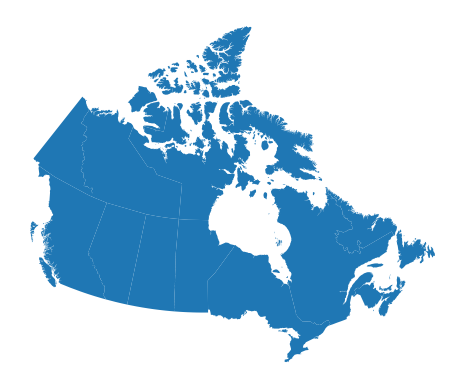

In [11]:
canada = gpd.read_file('data/Canada/Canada.shp')
#canada.plot()  # Basic plot showing boundaries of provinces/territories

# remove axis ticks and labels for a cleaner presentation:
ax = canada.plot()
ax.axis('off')  # Hide axis for a clean map view

You can visualize **categorical** data by setting the `categorical=True` flag and specifying a **colormap** using the `cmap` argument. For example, we can color provinces by their names using a qualitative colormap like `tab20` (https://matplotlib.org/2.0.2/users/colormaps.html):

(-2585080.5038594636, 3363410.5633306233, 97114.60776510829, 5035614.05220292)

<Figure size 640x480 with 0 Axes>

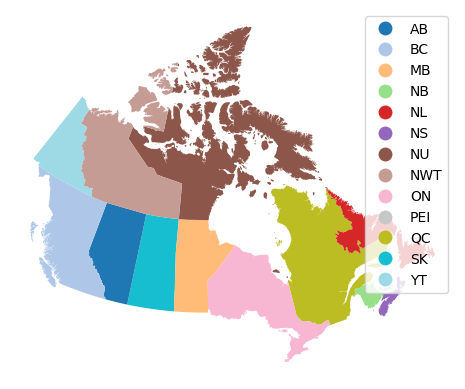

In [12]:
# Adding an abbreviated names column
canada['names'] = ('QC', 'NS', 'SK', 'AB', 'NL', 'BC', 'NB', 'PEI', 'YT', 'MB', 'ON', 'NU', 'NWT') # This adds a new column to the dataframe

# Map by the 'names' column with a color legend
plt.figure()
ax = canada.plot(categorical=True, cmap='tab20', column='names', legend=True)
# column='names' tells geopandas to use the 'names' column for coloring the provinces.
ax.axis('off')

### Merging Data

Lets add or **merge** Statscan census data (population in 2007, 2012, and 2017) to the dataframe to make the plot a bit more interesting. We will join the two datasets together by their common attribute: province/territory. And the key here is that they have the exact same name (e.g. 'NAME')!

In [13]:
# Load population data and inspect the first few rows
popn = pd.read_csv('data/canada-population.csv')
popn  # Inspect the dataframe

,NAME,popn_2007,popn_2012,popn_2017
0,Newfoundland and Labrador,509039,526450,528817
1,Prince Edward Island,137721,145080,152021
2,Nova Scotia,935071,944943,953869
3,New Brunswick,745407,756777,759655
4,Quebec,7692736,8085906,8394034
5,Ontario,12764195,13413702,14193384
6,Manitoba,1189366,1250265,1338109
7,Saskatchewan,1002048,1086018,1163925
8,Alberta,3514031,3880755,4286134
9,British Columbia,4290988,4546290,4817160


Let's use Boolean logic to test if the `NAME` columns match on both `canada` and `popn` dataframes:

In [14]:
# Convert the 'NAME' columns into lists
canada_sort = list(canada['NAME'])
popn_sort = list(popn['NAME'])

# Sort the lists
canada_sort.sort()
popn_sort.sort()

# Compare using Boolean logic
canada_sort == popn_sort

True

In [15]:
# Merge the population data with the shapefile based on 'NAME'
canada = canada.merge(popn, on="NAME")

# Check merged data
display(canada)

,NAME,NOM,geometry,names,popn_2007,popn_2012,popn_2017
0,Quebec,Québec,"MULTIPOLYGON (((899144.945 2633537.695, 906642...",QC,7692736,8085906,8394034
1,Nova Scotia,Nouvelle-Écosse,"MULTIPOLYGON (((2648595.571 1311422.122, 26473...",NS,935071,944943,953869
2,Saskatchewan,Saskatchewan,"POLYGON ((-329495.573 2233947.915, -330269.71 ...",SK,1002048,1086018,1163925
3,Alberta,Alberta,"POLYGON ((-1308811.606 1161810.354, -1306128.0...",AB,3514031,3880755,4286134
4,Newfoundland and Labrador,Terre-Neuve-et-Labrador,"MULTIPOLYGON (((2489315.841 2251482.159, 24999...",NL,509039,526450,528817
5,British Columbia,Colombie-Britannique,"MULTIPOLYGON (((-2282550.894 1945526.772, -227...",BC,4290988,4546290,4817160
6,New Brunswick,Nouveau-Brunswick,"MULTIPOLYGON (((2282092.019 1410312.165, 22842...",NB,745407,756777,759655
7,Prince Edward Island,Île-du-Prince-Édouard,"POLYGON ((2392269.944 1277724.026, 2381057.466...",PEI,137721,145080,152021
8,Yukon Territory,Territoire du Yukon,"MULTIPOLYGON (((-1567348.338 3815380.387, -156...",YT,32557,36058,38459
9,Manitoba,Manitoba,"POLYGON ((-329495.573 2233947.915, -221905.506...",MB,1189366,1250265,1338109


Text(0.5, 1.0, '2017 Population (Millions)')

<Figure size 640x480 with 0 Axes>

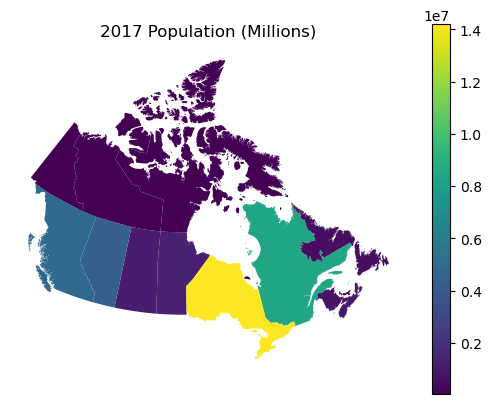

In [16]:
# Plot the population data for 2017 with a color scale
fig = plt.figure()
ax = canada.plot(column='popn_2017', legend=True, categorical=False)
ax.set_axis_off()  # Clean up by hiding axes
plt.title('2017 Population (Millions)')

### Shapefile Extents

The `total_bounds` function gives you the bounding box of the shapefile, in the CRS of the shapefile, providing the minimum and maximum x and y coordinates of the dataset. This can be useful to zoom into a specific region or ensure you're viewing the entire dataset.

In [17]:
# Get the geographic extents (bounding box) of the shapefile
minx, miny, maxx, maxy = canada.geometry.total_bounds
print(minx, miny)  # Print the minimum x and y coordinates (lower-left corner)

-2314694.546259914 321591.8552395543


## Cartopy and Geopandas
Let's put the two together. We will open simple shapefile using geopandas, create axes using cartopy, and then use the  `add_geometries` function to add the shapefile data to the cartopy map axes. 

In [18]:
# Load river data from the data folder
rivers = gpd.read_file('data/Lakes_and_Rivers_Shapefile/NA_Lakes_and_Rivers/data/hydrography_l_rivers_v2.shp')

# Print the first few rows of the data
print(rivers.head())

# Check the Coordinate Reference System (CRS) of the data
print(rivers.crs)

# Check the first few geometry objects in the shapefile
print(rivers.geometry[0:5])

    UIDENT  TYPE COUNTRY NAMEEN NAMEFR NAMESP EDIT_DATE EDIT    Shape_Leng  \
0  1097701    15      FN   None   None   None  20060803  NEW  32817.200911   
1  1099101    15      FN   None   None   None  20060803  NEW  18253.067277   
2  1099301    15      FN   None   None   None  20060803  NEW  21031.899166   
3  1098701    15      FN   None   None   None  20060803  NEW  14537.443280   
4  1097801    15      FN   None   None   None  20060803  NEW  22322.429132   

                                            geometry  
0  LINESTRING (686841.419 4506454.644, 687344.595...  
1  LINESTRING (668624.278 4487822.595, 667976.199...  
2  LINESTRING (682182.645 4485595.01, 682182.641 ...  
3  LINESTRING (683996.599 4489735.247, 683996.606...  
4  LINESTRING (707664.483 4504759.293, 704984.29 ...  
PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["D_Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943

Next, we'll use Cartopy to create a map of North America and add the river geometries to it. The `add_geometries` function from Cartopy allows us to display the river data on the map.

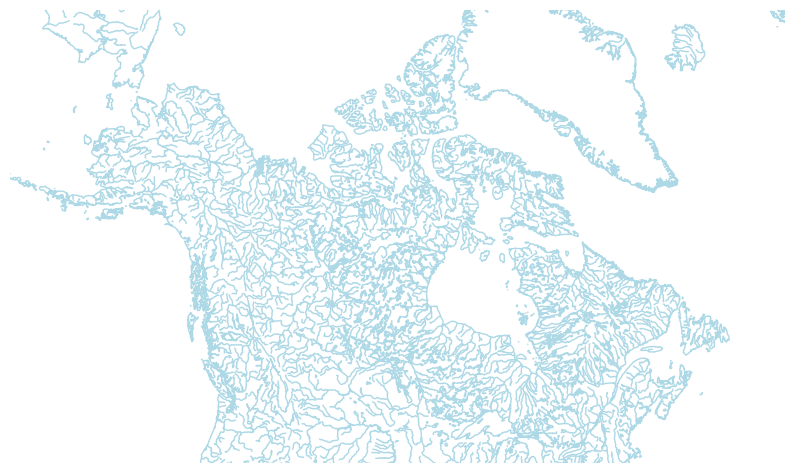

In [19]:
# Create a figure and axes
plt.figure(figsize=(10,10))

# Set up map axes using Lambert Azimuthal Equal Area projection centered at -100° longitude and 45° latitude
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(-100,45,0,0))

# Set extent (limits of the map) to cover part of North America
ax.set_extent([-145, -55, 35, 85])

# Add river geometries to the map
ax.add_geometries(rivers.geometry, crs=ccrs.LambertAzimuthalEqualArea(-100,45,0,0),
                  facecolor='None', edgecolor='lightblue', linewidth=1)

# Turn off the axis grid
ax.axis('off')

# Save the plot as a .png file
plt.savefig('Canada-Rivers.png', dpi=300)

Now, let's extract the Fraser River geometry and plot it on a map, alongside other rivers.

In [20]:
# see if "Fraser River" is in the dataframe:
rivers[rivers.NAMEEN == 'Fraser River']

,UIDENT,TYPE,COUNTRY,NAMEEN,NAMEFR,NAMESP,EDIT_DATE,EDIT,Shape_Leng,geometry
7609,1443201,17,CAN,Fraser River,Fraser River,Fraser River,20060803,NEW,111386.177660,"LINESTRING (2102536.248 1821632.498, 2105413.9..."
8517,1598801,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,3614.014114,"LINESTRING (-1453260.256 1218853.997, -1449684..."
8527,1598401,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,50569.083354,"LINESTRING (-1449684.891 1219381.119, -1448554..."
8549,1603101,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,19506.988310,"LINESTRING (-1466574.009 1205554.498, -1463766..."
8574,1602501,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,19179.086792,"LINESTRING (-1415352.006 1222484.38, -1413338...."
8698,1622701,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,77998.316073,"LINESTRING (-1466574.009 1205554.498, -1468240..."
8822,1631501,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,41062.421219,"LINESTRING (-1496257 1144289.118, -1494139.139..."
9209,1672001,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,153802.862230,"LINESTRING (-1483025.003 1105963.616, -1483609..."
9282,1667501,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,303869.710305,"LINESTRING (-1405157.766 1206493.628, -1401874..."
9532,1701401,17,CAN,Fraser River,Fleuve Fraser,Fraser River/Fleuve Fraser,20060803,NEW,133019.950746,"LINESTRING (-1518390.13 969537.063, -1518056.0..."


In [21]:
# extract one river from the database: the mighty Fraser
fraser = rivers[rivers.NAMEEN == 'Fraser River']

# What is the CRS?
print(fraser.crs)

PROJCS["Sphere_ARC_INFO_Lambert_Azimuthal_Equal_Area",GEOGCS["GCS_Sphere_ARC_INFO",DATUM["D_Sphere_ARC_INFO",SPHEROID["Sphere_ARC_INFO",6370997,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",45],PARAMETER["longitude_of_center",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Text(0.5, 1.0, 'The Mighty Fraser')

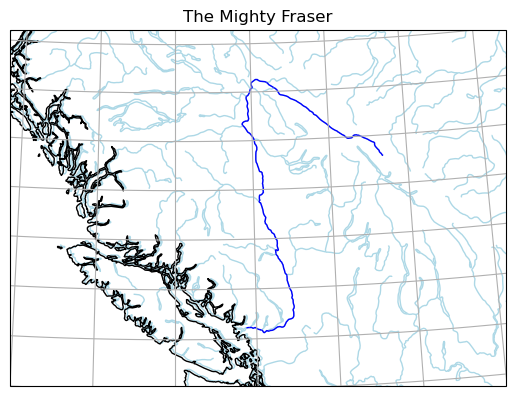

In [22]:
# Create a new figure
fig = plt.figure()

# Set up map axes with a different projection (Albers Equal Area)
central_lon, central_lat = -125, 50 # Define the central longitude and latitude for the Albers projection
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))

# Set the extent [xmin, xmax, ymin, ymax] 
ax.set_extent([-130, -115, 48, 55])

# Add the rivers to the map
ax.add_geometries(rivers.geometry, crs=ccrs.LambertAzimuthalEqualArea(-100, 45, 0, 0), facecolor='None', edgecolor='lightblue', linewidth=1)

# Add the Fraser River with a distinct color
ax.add_geometries(fraser.geometry, edgecolor='blue', facecolor='None', crs=ccrs.LambertAzimuthalEqualArea(-100, 45, 0, 0), linewidth=1)

# Add coastlines and gridlines
ax.coastlines(resolution='10m')
ax.gridlines()

# Add a title
plt.title('The Mighty Fraser')

**What's happening in this line of code?**
```
ax.add_geometries(fraser.geometry, edgecolor='blue', facecolor='None', crs=ccrs.LambertAzimuthalEqualArea(-100, 45, 0, 0), linewidth=1)
```
- The `crs=` argument tells Cartopy what coordinate reference system (CRS) the input geometries are in.
- `fraser.geometry` is already in Lambert Azimuthal Equal-Area (as confirmed by `fraser.crs`).
- `ccrs.LambertAzimuthalEqualArea(-100, 45, 0, 0)` is defining a Cartopy projection, which is separate from the CRS of the data itself.

**Exercise 3:** Modify the code above to select and select the **Nechako River** from the rivers dataset using its name. Add it to the map with a different color. Adjust the title to reflect the addition of the Nechako River.

# Linear Regressions

Linear regression is a fundamental statistical technique used to model the relationship between an **independent variable** (predictor) and a **dependent variable** (response). In simple linear regression, this relationship is expressed as:  

$y = mx + b$

where:  
- $y$ is the dependent variable (response)  
- $x$ is the independent variable (predictor)  
- $m$ is the slope of the line (rate of change)  
- $b$ is the y-intercept (value of $y$ when $x = 0$)  

The goal of linear regression is to find the best-fitting line that minimizes the error between the predicted values and the actual data points.  

---

**Python Packages for Linear Regression**

In Python, we can perform linear regression using the `scikit-learn` library (`sklearn.linear_model.LinearRegression`).

*Note on scikit-learn:*

- The `fit()` method for `LinearRegression` expects the input features (independent variables, X) to be a 2D array, even if there's only one feature. 
- The dependent variable (Y) can stay as a 1D array, which is the expected format for regression in scikit-learn.

## Linear Regression of snow depth data

**Step 0: Package preamble**

In [23]:
from sklearn.linear_model import LinearRegression # Linear Regression function

**Step 1: Load the data**

Let's look back at the CSV containing snow depth data we used to create a scatter plot.

In [24]:
# Read the CSV file, specifying the delimiter and header row
df = pd.read_csv('data/bcsnowdepthswetrendsbystation1950-2014.csv', delimiter=',', header=0)  

# Display the DataFrame
display(df)

,station_id,latitude,longitude,elevation,measure,slope_percentperyear,slope_lci,slope_uci,sigstat,intercept,start_year,end_year
0,1A05,53.950000,-121.433333,1693,swe,0.462782,0.059162,0.804084,True,-915.364369,1953,2014
1,1B01,53.716667,-126.416667,1489,swe,-0.127336,-0.476677,0.220633,False,251.437277,1953,2014
2,1B02,53.583333,-127.633333,1319,swe,0.199319,-0.035205,0.451716,False,-399.949880,1952,2014
3,1B06,53.350000,-125.266667,1596,swe,-0.170294,-0.531350,0.177117,False,337.079676,1953,2014
4,1B07,53.450000,-126.283333,1502,swe,-0.227871,-0.584958,0.132671,False,451.361593,1953,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
93,3A10,49.366667,-122.950000,1007,depth,-0.514669,-1.070323,0.112818,False,1030.805848,1950,2014
94,3B01,49.650000,-125.200000,1110,depth,-0.411571,-0.918675,0.160674,False,824.851130,1955,2014
95,3D02,49.033333,-120.850000,1254,depth,-0.825228,-1.353565,-0.349187,True,1653.571244,1950,2014
96,3D03A,49.116667,-121.300000,1134,depth,-1.404211,-2.654260,-0.185798,True,2820.478352,1950,2014


In [25]:
# Extract independent and dependent variables
elevation = df['elevation']  # Independent variable
snow_trend = df['slope_percentperyear']  # Dependent variable

In [26]:
# Check shapes of the variables
print(elevation.values.shape)
print(snow_trend.values.shape)

(98,)
(98,)


This means that both are 1D Arrays. We will need to convert the independent variable (`elevation`) to a 2D array for scikit to properly process the input.

**Step 2: Fit a Linear Regression Model**

In [27]:
# Reshape the elevation data for regression
elevation_reshaped = elevation.values.reshape(-1, 1)  # Convert elevation to a 2D array

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(elevation_reshaped, snow_trend)

## Alternate syntax: 
# model = LinearRegression().fit(elevation_reshaped, snow_trend)

# Get the regression line (predicted values)
regression_line = model.predict(elevation_reshaped)


- `LinearRegression().fit(X, y)` trains the model by finding the best-fit line.
- The `.predict(X)` function generates predicted values based on the model.

- The `.reshape(-1, 1)` is necessary because `sklearn` expects the input data as a 2D array. It tells NumPy to convert a 1D array into a 2D array with one column.
    - `-1`: This is a placeholder that tells NumPy to automatically determine the correct number of rows. Since we don't want to manually count the number of samples, NumPy figures it out for us.
    - `1`: This specifies that we want one column (because we only have one predictor variable: elevation).
- Why must we pass `.values` before `.reshape()`?
    - Essentially, we need to convert the independent variable (elevation) to a `NumPy` array in order for `.reshape()` to work because `.reshape()` is a `NumPy` operation

**Step 3: Calculate R² (Coefficient of Determination)**

In [28]:
# Calculate R-squared value
r2 = model.score(elevation_reshaped, snow_trend)

# Print R² value
print(f"R² value: {r2:.3f}")

R² value: 0.076


- The R² value measures how well the regression model explains the variability in the data.
- Values closer to 1.0 indicate a strong relationship, while values closer to 0 suggest a weak or no relationship.

**Step 4: Plot the Data and Regression Line**

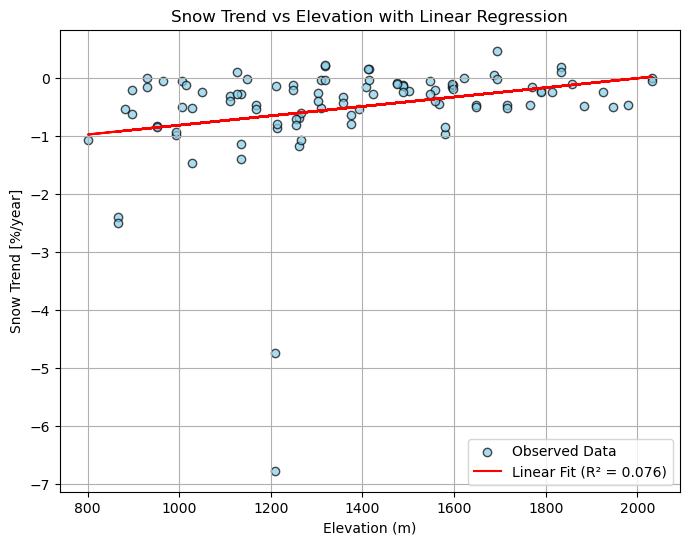

In [29]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(elevation, snow_trend, color='skyblue', alpha=0.7, edgecolors='black', label="Observed Data")

# Plot the regression line
plt.plot(elevation, regression_line, color='red', linestyle='-', label=f'Linear Fit (R² = {r2:.3f})')

# Add labels and title
plt.xlabel('Elevation (m)')
plt.ylabel('Snow Trend [%/year]')
plt.title('Snow Trend vs Elevation with Linear Regression')

# Show grid and plot
plt.grid(True)
plt.legend(loc='lower right')

## Linear Regression of CO2 data

Using the steps learned above, let's perform another linear regression on the Keeling Curve, monitoring CO2 measurements from the Mauna Loa Observatory.

We will plot `decimal date` as the independent variable and `average` as the dependent variable.

In [30]:
# Read the CSV file, skipping the first 40 rows to set the correct header
df = pd.read_csv('data/co2_mm_mlo.csv', delimiter=',', skiprows=40)

# Display the DataFrame
display(df)

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.71,314.44,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.69,-1,-9.99,-0.99
3,1958,6,1958.4548,317.27,315.15,-1,-9.99,-0.99
4,1958,7,1958.5370,315.87,315.20,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
797,2024,8,2024.6250,422.99,424.84,22,1.08,0.44
798,2024,9,2024.7083,422.03,425.43,18,0.41,0.18
799,2024,10,2024.7917,422.38,425.66,22,0.35,0.14
800,2024,11,2024.8750,423.85,425.86,24,0.33,0.13


R² Score from model.score(): 0.9761


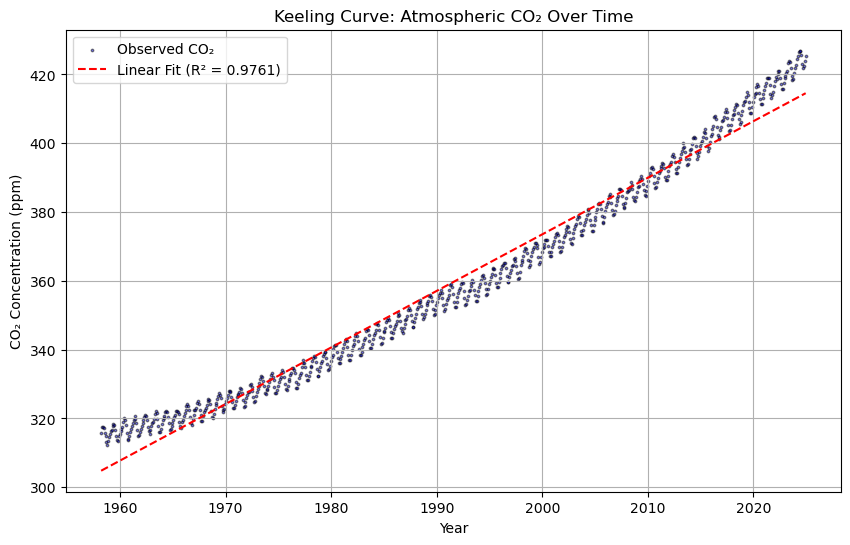

In [66]:
# Extract decimal date (time) and average CO₂ concentration (ppm)
date = df['decimal date'].values.reshape(-1, 1)  # Independent variable (time)
CO2 = df['average']       # Dependent variable (CO₂ concentration)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(date, CO2)

# Compute R² score using model.score()
r2 = model.score(date, CO2)

# Generate predictions for the regression line
CO2_pred = model.predict(date)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(date, CO2, color='blue', alpha=0.5, edgecolors='black', label='Observed CO₂', s=3)

# Plot the regression line
plt.plot(date, CO2_pred, color='red', linestyle='--', label=f'Linear Fit (R² = {r2:.4f})')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Keeling Curve: Atmospheric CO₂ Over Time')
plt.legend()
plt.grid(True)

# Print R² value
print(f"R² Score from model.score(): {r2:.4f}")

**Exercise 4:** Examine the linear regression line fitted to the observed CO2 data above. Do you think the linear model provides a good fit? Justify your answer using R-squared metrics and/or visual inspection. Additionally, could another type of regression offer a better fit for this data?

### Time Slicing
A simple way to examine different periods of time in a dataframe is to edit the df directly.

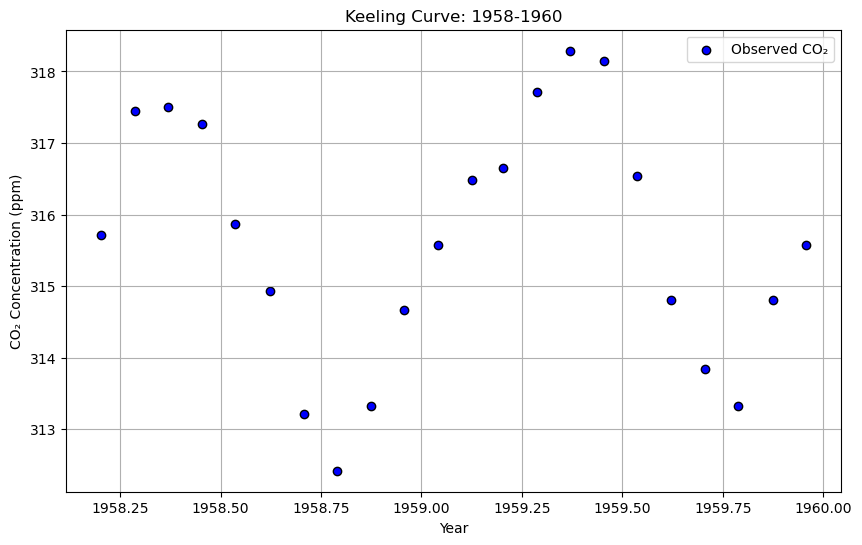

In [87]:
# Read the CSV file
df = pd.read_csv('data/co2_mm_mlo.csv', delimiter=',', skiprows=40)

# Time slice
df = df[df['year'] < 1960]

# Extract decimal date (time) and average CO₂ concentration (ppm)
date = df['decimal date'].values.reshape(-1, 1)  # Independent variable (time)
CO2 = df['average']       # Dependent variable (CO₂ concentration)

# Plot the original data
plt.figure(figsize=(10, 6))
plt.scatter(date, CO2, color='blue', edgecolors='black', label='Observed CO₂')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('CO₂ Concentration (ppm)')
plt.title('Keeling Curve: 1958-1960')
plt.legend()
plt.grid(True)


**Exercise 5:** Using the CO2 data, plot the best fit line using the `deseasonalized` data. Time slice the data so it only calculates the regression and plots data between 1980 and 2000 (inclusive). *Extra: Play around with the colours and labeling to make a visually exciting plot.*

Hint:
- Square brackets `[]` are used to index/access elements in DataFrames.
- Parentheses `()` are used to group conditions and control the order of operations in expressions.

# End of Lab 3